In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from json import JSONEncoder
import json
import time
import random
from operator import itemgetter
import numpy as np
import gym
import matlab.engine
from IPython import display
import os
import argparse
import cv2
from IPython.display import clear_output

### Declare env as the environment:mapHR-v1

In [2]:
env = gym.make('gym_mapHR_v1:mapHR-v1')

/home/morris/RL-demo-web/backend/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/morris/RL-demo-web/backend/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


### Set state


ans =

     0



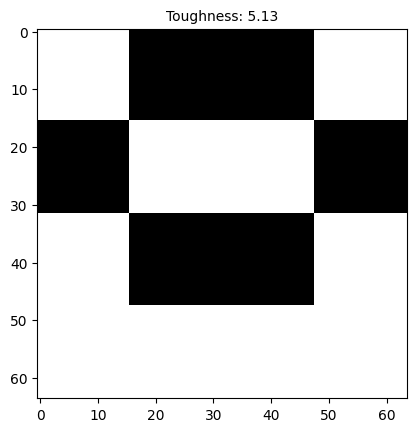

In [3]:
# system size
size = 4
# randomly generated combinations
state_0 = np.random.randint(2, size=size*int(size/2)) 
# state_0 = [0,1,2]
# set the system size and current state
env.ENVsize(size,state_0.reshape(size*int(size/2))) 
env.plotmap_now()   

In [30]:
# set parameters
# training times
episodes_list = [100, 400, 1000, 3500] 
# the number of actions is performed in an episode
iterations_list = [8, 12, 50, 90]
# learning rate
alpha = 0.4         
# the importance of future rewards
gamma = 0.99         
# randomness of action
epsilon = 1 
# minimum value of epsilon
epsilon_min = 0.001 
#　When does the episode reach the minimum value
final_dec_ep_list = [20, 50, 50, 500] 
# number of times to enlarge the system size
increase_times = 3    



ans =

     0



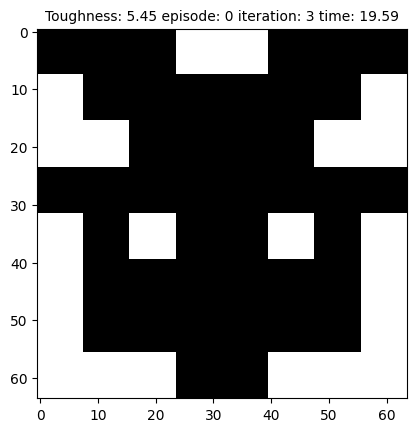

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

<Figure size 640x480 with 0 Axes>

In [32]:
read_data = 0
read_q_table = 0
# whether to occasionally use other combinations as the initial state
inb = 1 
# initialization
# starting time
start_time = time.time()     
initmap = np.array(env.reset().reshape(1,int(size*size/2)))

for ss in range(increase_times+1):
    # initialization
    episodes = episodes_list[ss]
    iterations = iterations_list[ss]
    alpha = 0.4          
    gamma = 0.99         
    epsilon = 1          
    epsilon_min = 0.001
    # decay rate of epsilon 
    epsilon_decay = epsilon_min**(1/(episodes-final_dec_ep_list[ss]))
    max_lengh = 5
    top_map = [0]
    top_map_ep = [0]
    top_map_it = [0]
    top_map_time = [0]
    length = 0
    best_num = 0
    env.ENVsize(size,initmap)
    #　current state
    state = initmap  
    # id of the current state
    state_id = 0    
    training_rewards = [] 
    
    if read_data == 1:
        state_id_table = pd.read_csv(str(size)+'_state_table.txt',delim_whitespace=True, header=None).values
        toughness_table = pd.read_csv(str(size)+'_t_table.txt',delim_whitespace=True, header=None).values
        toughness_table = list(toughness_table.reshape(toughness_table.shape[0]))
    else:
        # build state table
        state_id_table = initmap 
        # build toughness table
        toughness_table = [float(env.toughness(state_id_table))]    
    if read_q_table == 1:
        q_table = pd.read_csv(str(size)+'_q_table.txt',delim_whitespace=True, header=None).values
    else:
        # build q_table
        q_table = 0.00001*np.round(np.random.randn(1, size*int(size/2)), decimals = 2)    
    
    #　the property of the current state
    toughness_now = float(env.toughness(state_id_table[0]))    
    top_tou = [toughness_now]   
    # the property of the initial state
    toughness_0 = toughness_now     
    env.plotmap_save(state_id_table[0],(np.round(time.time() - start_time, decimals = 2)),0,0) 
    initmap_pd = pd.DataFrame(data=state_id_table)    
    initmap_pd.to_csv(str(size)+'initmap.txt', header=None, index=None, sep=' ', mode='w')
    
    for ep in range(episodes):

        rewards = 0

        for it in range(iterations):
            
            Higher_tou = 0
            #　generate random numbers to determine the randomness of actions
            exp_tradeoff = random.uniform(0, 1) 
            
            if exp_tradeoff > epsilon:
                # action determined by q table
                action = np.argmax(q_table[state_id,:])       #由q_table決定動作
                
            else:
                # random action
                action = random.sample(list(np.arange(0,int(size*size/2))) ,1)      
           
            # new state
            last_state = env.step(action)
            last_state_re = np.array([last_state[0:int(size*size/2)]])
            
            # check for the same state
            for i in range(state_id_table.shape[0]):
                
                same_map = np.array_equal(state_id_table[i], np.array(last_state_re[0])) 
                if same_map == True:     
                    last_state_id = i
                    toughness_2 = toughness_table[i]   
                    break
                elif i == state_id_table.shape[0]-1:  
                    state_id_table = np.concatenate((state_id_table, last_state_re), axis=0)
                    toughness_2 = env.toughness(last_state_re)
                    toughness_table.append(toughness_2) 
                    last_state_id= state_id_table.shape[0]-1
                    q_table = np.concatenate((q_table, 0.00001*np.round(np.random.randn(1, size*int(size/2)), 
                                                                        decimals = 2)), axis=0)
            # get reward                        
            reward, Higher_tou= env.get_rewaed(toughness_now, toughness_2,
                                                     toughness_table[int(top_map[len(top_map)-1])]) 
        
            # save better state
            if Higher_tou == 1: 
                if length >=  max_lengh:
                    top_map.pop(0)  
                    top_map_ep.pop(0) 
                    top_map_it.pop(0) 
                    top_map_time.pop(0)
                    top_tou.pop(0)
                    length -= 1
                    env.plotmap_save(last_state_re,(np.round(time.time() - start_time, decimals = 2)),ep,it)
                top_map.append(int(last_state_id))
                top_map_ep.append(ep+1)
                top_map_it.append(it+1)
                top_map_time.append((np.round(time.time() - start_time, decimals = 2)))
                top_tou.append(toughness_2)
                length += 1    
                best_num = last_state_id
            
            # update q table
            q_table[state_id, action] += alpha * (reward + gamma * 
                                                  (np.max(q_table[last_state_id, :])) - q_table[state_id, action]) 
            # reward accumulation
            rewards += reward     
            # update state
            state = last_state
            # update state id
            state_id = last_state_id     
            # update the property of the current state
            toughness_now = toughness_2

    
            # show current status
            if int((it)%1) == 0:
                env.showmap(ep,it,(np.round(time.time() - start_time, decimals = 2))) 
                #clear_output()
                #print("Toughness: {} episode: {} iteration: {} time: {}" .format(np.round(toughness_2, decimals = 2),ep, it, (np.round(time.time() - start_time, decimals = 2))))
        
        # epsilon greedy
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay  
    
        training_rewards.append(rewards)
        
        if ep >= episodes-final_dec_ep_list[ss]:
            inb = 0
            
        # use a better state as the initial state every 5 episodes    
        if inb == 1:
            if int((ep%5))== 0: 
                env.ENVsize(size,state_id_table[int(top_map[len(top_map)-1])])
                state = env.reset()
                state_id = int(top_map[len(top_map)-1])
                toughness_now = top_tou[len(top_map)-1]
            else:
                env.ENVsize(size,np.array(initmap,int))
                state = env.reset()
                state_id = 0
                toughness_now = toughness_0
        else:
            env.ENVsize(size,np.array(initmap,int))
            state = env.reset()
            state_id = 0
            toughness_now = toughness_0
            
        # storage table and reward accumulation every 100 episodes        
        if int((ep%100))== 0:   
            q_pd = pd.DataFrame(data=q_table)
            q_pd.to_csv(str(size)+'_q_table.txt', header=None, index=None, sep=' ', mode='w')
            state_id_table_df= pd.DataFrame(data=state_id_table)
            state_id_table_df.to_csv(str(size)+'_state_table.txt', header=None, index=None, sep=' ', mode='w')
            tt_pd = pd.DataFrame(data=toughness_table)
            tt_pd.to_csv(str(size)+'_t_table.txt', header=None, index=None, sep=' ', mode='w')
            ep_hl = np.arange(ep+1)+1       
            plt.figure()
            plt.plot(ep_hl,training_rewards)
            plt.xlabel('episode')
            plt.ylabel('reward')
            plt.title('episode_rewards'+str(ss+1))
            plt.legend()  
            plt.show
            plt.savefig('episode_rewards'+str(ss+1))
            plt.clf()
    
    # enlarge the best state
    next_initmap = state_id_table[best_num]
    env.plotmap_save(next_initmap,(np.round(time.time() - start_time, decimals = 2)),ep,it)
    next_initmap_pd = pd.DataFrame(data=next_initmap)
    next_initmap_pd.to_csv(str(size)+'best.txt', header=None, index=None, sep=' ', mode='w')
    next_initmap = next_initmap.reshape(size,int(size/2))
    # pixel*2 ex:8*8-->16*16 
    state_0 = next_initmap
    state_inc = np.ones((size*2,size))
    for i in range(0, size*2, 2):
        state_inc[i][0:state_inc.shape[1]+1:2] = state_0[int(i/2)]
        state_inc[i][1:state_inc.shape[1]+1:2] = state_0[int(i/2)]
        state_inc[i+1] = state_inc[i] 
    state_0 = state_inc
    
    initmap = np.array(state_inc,'int')
    
    # store the table and reward accumulation
    map_1 = initmap
    next_initmap_L = map_1.reshape((size*2,size))
    next_initmap_R = np.fliplr(next_initmap_L)
    ind_map = np.block([next_initmap_L, next_initmap_R])
    map_2 = ind_map.reshape(size*size*4)
    q_pd = pd.DataFrame(data=q_table)
    q_pd.to_csv(str(size)+'_q_table.txt', header=None, index=None, sep=' ', mode='w')
    state_id_table_df= pd.DataFrame(data=state_id_table)
    state_id_table_df.to_csv(str(size)+'_state_table.txt', header=None, index=None, sep=' ', mode='w')
    tt_pd = pd.DataFrame(data=toughness_table)
    tt_pd.to_csv(str(size)+'_t_table.txt', header=None, index=None, sep=' ', mode='w')
    initmap = initmap.reshape(1,size*2*size)
    size = size*2
    
    #save rewards
    ep_l = np.arange(ep+1)+1
    ep_l_pd = pd.DataFrame(ep_l)
    ep_l_pd.to_csv('ep.txt', header=None, index=None, sep=' ', mode='w')
    training_rewards_pd = pd.DataFrame(training_rewards)
    training_rewards_pd.to_csv('rewards.txt', header=None, index=None, sep=' ', mode='w')
    
    # Plot reward
    plt.figure()
    plt.plot(ep_l,training_rewards)
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.title('episode_rewards'+str(ss+1))
    plt.legend()  
    plt.savefig('episode_rewards'+str(ss+1))
    plt.show()
    plt.clf()